In [35]:
import os
import cv2
import re
import numpy as np
from tqdm import tqdm

## Creating pairs

In [36]:
# Paths to the datasets
lc_base_path = "/kaggle/input/sen12ms-smaller-samples/labels"
sar_base_path = "/kaggle/input/sen12ms-smaller-samples/sar"

def create_image_pairs():
    """Create dictionary of matching SAR-Label image pairs."""
    # Load LC dictionary
    print("Creating LC dictionary...")
    lc_dict = {}
    for file in os.listdir(lc_base_path):
        if file.endswith(".tif"):
            match = re.search(r"ROIs1868_summer_lc_(\d+)_p(\d+)", file)
            if match:
                lc_id, patch_id = match.groups()
                lc_id, patch_id = int(lc_id), int(patch_id)
                if lc_id not in lc_dict:
                    lc_dict[lc_id] = {}
                lc_dict[lc_id][patch_id] = os.path.join(lc_base_path, file)

    # Load SAR dictionary
    print("Creating SAR dictionary...")
    sar_dict = {}
    for file in os.listdir(sar_base_path):
        if file.endswith(".png"):
            match = re.search(r"s(\d{6})_p(\d{6})", file)
            if match:
                s_id, p_id = match.groups()
                s_key, p_value = int(s_id), int(p_id)
                if s_key not in sar_dict:
                    sar_dict[s_key] = {}
                sar_dict[s_key][p_value] = os.path.join(sar_base_path, file)

    # Find matching pairs
    print("Finding matching pairs...")
    all_pairs = []
    common_keys = set(lc_dict.keys()) & set(sar_dict.keys())
    
    for key in common_keys:
        common_patches = set(lc_dict[key].keys()) & set(sar_dict[key].keys())
        for patch in common_patches:
            all_pairs.append((lc_dict[key][patch], sar_dict[key][patch]))
    
    print(f"Found {len(all_pairs)} total pairs")
    return all_pairs

In [37]:
all_pairs = create_image_pairs()

Creating LC dictionary...
Creating SAR dictionary...
Finding matching pairs...
Found 1250 total pairs


In [38]:
all_pairs[0]

('/kaggle/input/sen12ms-smaller-samples/labels/ROIs1868_summer_lc_129_p653.tif',
 '/kaggle/input/sen12ms-smaller-samples/sar/ROIs1868_summer_s000129_p000653.png')

SAR image shape: (256, 256, 4)
SAR_first channel only image shape: (256, 256)
Label image shape: (256, 256, 4)
label_first_channel shape: (256, 256)


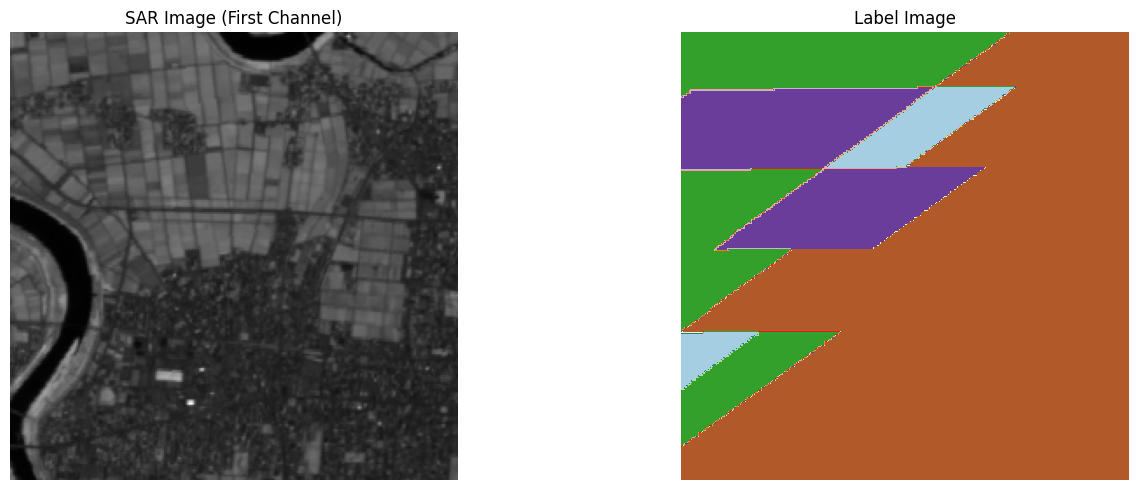

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_pair(label_path, sar_path):

    plt.figure(figsize=(15, 5))
    
    # Load SAR image and extract first channel
    sar_image = np.array(Image.open(sar_path))
    print("SAR image shape:", sar_image.shape)
    sar_first_channel = sar_image[:,:,0]
    print("SAR_first channel only image shape:", sar_first_channel.shape)
    
    # Load label image
    label_image = np.array(Image.open(label_path))
    print("Label image shape:", label_image.shape)
    label_to_show = label_image[:,:,0]
    print("label_first_channel shape:", label_to_show.shape)
    
    # Display SAR image (first channel)
    plt.subplot(1, 2, 1)
    plt.imshow(sar_first_channel, cmap='gray')
    plt.title('SAR Image (First Channel)')
    plt.axis('off')
    
    # Display label image
    plt.subplot(1, 2, 2)
    plt.imshow(label_to_show, cmap='Paired')
    plt.title('Label Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    # Visualize the first pair
    if all_pairs:
        visualize_pair(all_pairs[0][0], all_pairs[0][1])
    else:
        print("No image pairs found.")

if __name__ == '__main__':
    main()

## Loading the dataset in arrays

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_image_datasets(all_pairs):
    image_dataset = []
    label_dataset = []
    
    for label_path, sar_path in all_pairs:
        try:
            # Load SAR image and extract first channel
            sar_image = np.array(Image.open(sar_path))
            sar_first_channel = sar_image[:,:,0] 
            
            # Load label image and extract first channel
            label_image = np.array(Image.open(label_path))
            label_first_channel = label_image[:,:,0] 
            
            image_dataset.append(sar_first_channel)
            label_dataset.append(label_first_channel)
            
        except Exception as e:
            print(f"Error loading image pair: {label_path}, {sar_path}")
            print(f"Error details: {e}")
    
    return np.array(image_dataset), np.array(label_dataset)

In [41]:
if all_pairs:
    # Load entire dataset
    image_dataset, label_dataset = load_image_datasets(all_pairs)
        
    print("Image Dataset Shape:", image_dataset.shape)
    print("Label Dataset Shape:", label_dataset.shape)
else:
    print("No image pairs found.")

Image Dataset Shape: (1250, 256, 256)
Label Dataset Shape: (1250, 256, 256)


SAR image shape: (256, 256)
Label image shape: (256, 256)


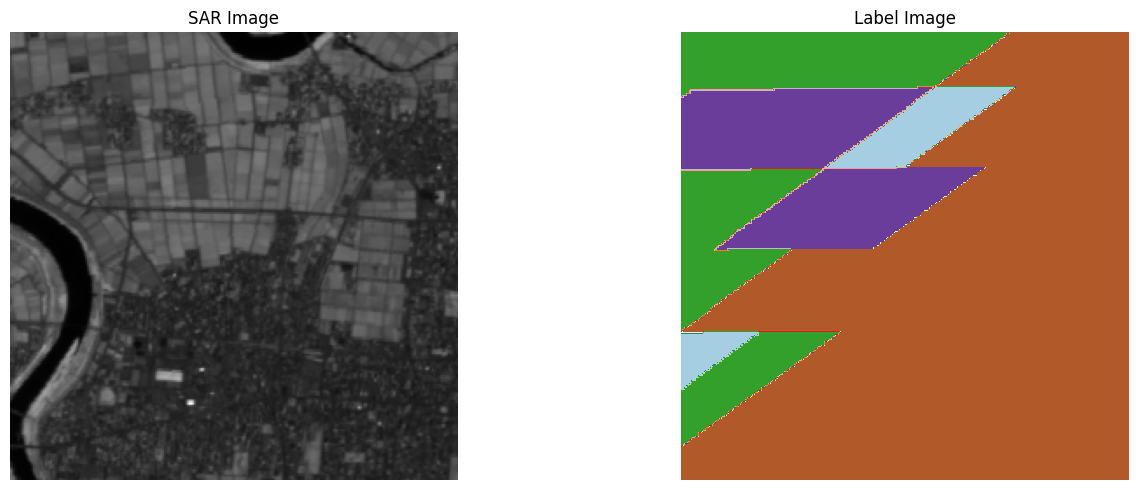

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize(label, image):

    plt.figure(figsize=(15, 5))

    print("SAR image shape:", image.shape)
    
    print("Label image shape:", label.shape)
    
    # Display SAR image (first channel)
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('SAR Image')
    plt.axis('off')
    
    # Display label image
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='Paired')
    plt.title('Label Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



visualize(label_dataset[0], image_dataset[0])

## Creating patches (Patching images)

In [43]:
def create_patches(image_dataset, label_dataset, patch_size=128, step=128):
    all_sar_patches = []
    all_label_patches = []
    
    # Ensure both datasets have the same number of images
    assert len(image_dataset) == len(label_dataset), "Dataset sizes must match"
    
    for i in range(len(image_dataset)):
        sar_image = image_dataset[i]
        label_image = label_dataset[i]
        
        height, width = sar_image.shape
        
        for y in range(0, height - patch_size + 1, step):
            for x in range(0, width - patch_size + 1, step):
                # Extract SAR patch
                sar_patch = sar_image[y:y+patch_size, x:x+patch_size]
                
                # Extract corresponding label patch from SAME coordinates
                label_patch = label_image[y:y+patch_size, x:x+patch_size]
                
                # Append patches
                all_sar_patches.append(sar_patch)
                all_label_patches.append(label_patch)
    
    print(f"Total SAR patches created: {len(all_sar_patches)}")
    print(f"Total Label patches created: {len(all_label_patches)}")
    
    return np.array(all_sar_patches), np.array(all_label_patches)

# Example usage
sar_patches, label_patches = create_patches(image_dataset, label_dataset)

Total SAR patches created: 5000
Total Label patches created: 5000


In [44]:
label_patches.shape

(5000, 128, 128)

SAR image shape: (128, 128)
Label image shape: (128, 128)


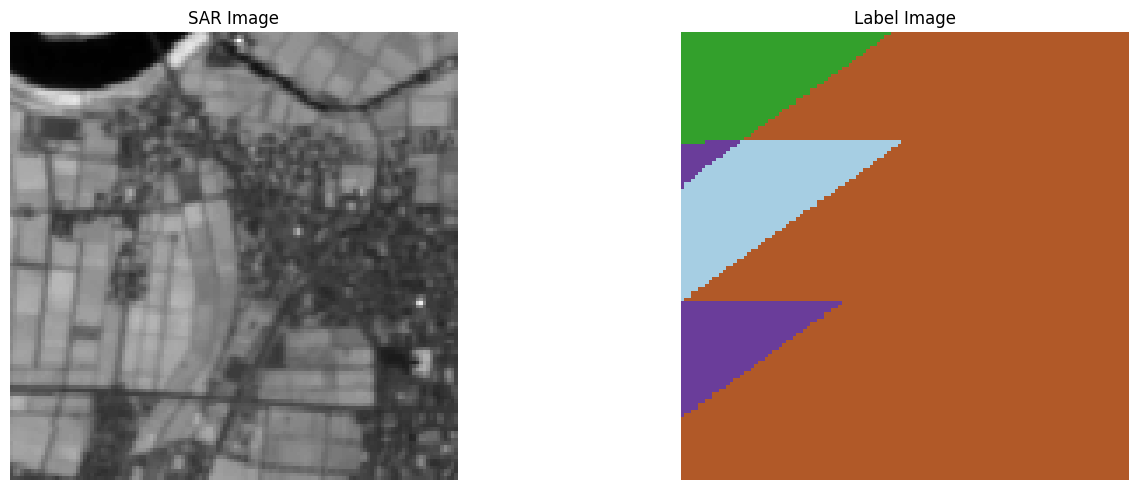

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize(label, image):

    plt.figure(figsize=(15, 5))

    print("SAR image shape:", image.shape)
    
    print("Label image shape:", label.shape)
    
    # Display SAR image (first channel)
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('SAR Image')
    plt.axis('off')
    
    # Display label image
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='Paired')
    plt.title('Label Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



visualize(label_patches[1],sar_patches[1])

## Merging classes

In [46]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        # tree
        1: 9,
        2: 9, 
        3: 9, 
        4: 9,  
        5: 9,
        6: 9,
        7: 9,
        8: 9,

        #bareland
        10: 12,
        14: 12,
        16: 12,

        #water
        11: 17,
        15: 17
        
        
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        12: 0,  # Bareland
        13: 1,  # Builtup
        9: 2,  # Tree
        17: 3,  # Water
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy

In [47]:
labels_dataset = []
for i in range(label_patches.shape[0]):
        merged_mask = merge_classes(label_patches[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (5000, 128, 128)


In [48]:
np.unique(labels_dataset)

array([0, 1, 2, 3], dtype=uint8)

In [49]:
np.unique(label_patches)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

In [50]:
#Validation
before_Evergreen_Needleleaf_Forests = len(np.where(label_patches.flatten()==1)[0])
before_Evergreen_Broadleaf_Forests =   len(np.where(label_patches.flatten()==2)[0])
before_Deciduous_Needleleaf_Forests =   len(np.where(label_patches.flatten()==3)[0])
before_Deciduous_Broadleaf_Forests =   len(np.where(label_patches.flatten()==4)[0])
before_Mixed_Forests =   len(np.where(label_patches.flatten()==5)[0])
before_Closed_Shrublands =   len(np.where(label_patches.flatten()==6)[0])
before_Open_Shrublands =   len(np.where(label_patches.flatten()==7)[0])
before_Woody_Savannas =   len(np.where(label_patches.flatten()==8)[0])
before_Savannas =   len(np.where(label_patches.flatten()==9)[0])
before_Grasslands =   len(np.where(label_patches.flatten()==10)[0])
before_Permanent_Wetlands =   len(np.where(label_patches.flatten()==11)[0])
before_Croplands =   len(np.where(label_patches.flatten()==12)[0])
before_Built_Up_Lands =   len(np.where(label_patches.flatten()==13)[0])
before_Natural_Vegetation_Mosaics =   len(np.where(label_patches.flatten()==14)[0])
before_Permanent_Snow_and_Ice =   len(np.where(label_patches.flatten()==15)[0])
before_Barrens =   len(np.where(label_patches.flatten()==16)[0])
before_Water =   len(np.where(label_patches.flatten()==17)[0])

after_Water =   len(np.where(labels_dataset.flatten()==3)[0])
after_Tree =   len(np.where(labels_dataset.flatten()==2)[0])
after_Bareland =   len(np.where(labels_dataset.flatten()==0)[0])
after_Builtup =   len(np.where(labels_dataset.flatten()==1)[0])

assert before_Built_Up_Lands == after_Builtup, "Builtup does not match"

assert (before_Grasslands+before_Croplands+before_Natural_Vegetation_Mosaics+before_Barrens) == after_Bareland,"Bareland does not match"

assert (before_Evergreen_Needleleaf_Forests+before_Evergreen_Broadleaf_Forests+before_Deciduous_Needleleaf_Forests+
    before_Deciduous_Broadleaf_Forests+before_Mixed_Forests+before_Closed_Shrublands+
    before_Open_Shrublands+before_Woody_Savannas+before_Savannas) == after_Tree, "Trees does not match"

assert (before_Water+before_Permanent_Wetlands+before_Permanent_Snow_and_Ice) == after_Water, "Water does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Tree/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Bareland/(labels_dataset.flatten().shape[0]), 3),
                        ' Builtup = ', np.round(after_Builtup/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.121  Trees =  0.449  Bareland =  0.344  Builtup =  0.086


## Model Building & Training

In [51]:
n_classes = 4

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

def residual_unit(x, filters):
    """Efficient residual block with reduced parameters"""
    skip = x
    if x.shape[-1] != filters:
        skip = Conv2D(filters, 1, use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', use_bias=False)(x)

    return Add()([skip, x])

def build_frrnb(input_shape=(128, 128, 1), n_classes=4):
    """Efficient FRRN-b with optimized architecture"""
    inputs = Input(input_shape)

    # Initial convolution
    x = Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual stream
    z = x

    # Pooling stream
    y = MaxPooling2D()(x)
    y = Conv2D(64, 3, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # First set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Further pooling
    y = MaxPooling2D()(y)
    y = Conv2D(128, 3, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Middle set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Upsampling path
    y = Conv2DTranspose(64, 3, strides=2, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Final set of residual blocks
    for _ in range(2):
        z = residual_unit(z, 32)

    # Merge streams
    y = Conv2DTranspose(32, 3, strides=2, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Concatenate and final convolution
    x = Concatenate()([y, z])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [53]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Prepare data
X = sar_patches.reshape(-1, 128, 128, 1)
y = tf.keras.utils.to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_frrnb()

callback = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('frrn_b_sen12ms.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=callback)

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.4642 - loss: 1.1295 - val_accuracy: 0.4467 - val_loss: 1.1642 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5088 - loss: 1.0269 - val_accuracy: 0.5241 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5211 - loss: 1.0182 - val_accuracy: 0.4350 - val_loss: 1.0873 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5372 - loss: 1.0042 - val_accuracy: 0.5503 - val_loss: 0.9987 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5423 - loss: 0.9937 - val_accuracy: 0.4294 - val_loss: 1.1816 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.5516 - loss: 0.9841 - val_accuracy: 0.5064 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5

In [54]:
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## Model Evaluation

In [55]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf
from scipy import stats

In [56]:
code_label ={'Bareland':0, 'Builtup':1, 'Tree':2, 'Water':3}

In [57]:
# Split data
from sklearn.model_selection import train_test_split
X_train2, X_val2, y_train2, y_val2 = train_test_split(sar_patches, labels_dataset, test_size=0.2, random_state=42)

In [58]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Tree =   len(np.where(flat_pixels==code_label['Tree'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Tree = ', np.round(after_Tree/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' Builtup = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [59]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [60]:
full_map_predictions = model.predict(X_val2)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
(1000, 128, 128, 4)


In [61]:
from sklearn.metrics import classification_report

report=classification_report(y_val2.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Bareland,0.599716,0.458781,0.519866,5.445664e+06
Builtup,0.494529,0.201487,0.286319,1.321092e+06
Tree,0.610479,0.809459,0.696028,7.653820e+06
Water,0.836231,0.652196,0.732837,1.963424e+06
accuracy,0.625033,0.625033,0.625033,6.250330e-01
macro avg,0.635239,0.530481,0.558762,1.638400e+07
weighted avg,0.624606,0.625033,0.608850,1.638400e+07


In [62]:
pd.DataFrame.from_dict( compute_class_wise_iou(y_val2.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Bareland,0.351229
Builtup,0.167078
Tree,0.533775
Water,0.578328
mean_iou,0.407602
weighted_iou,0.448872


In [63]:
y_true=y_val2.flatten()
y_pred=full_map_reshape

In [64]:
# 1. Overall Metrics
print("\n=== Overall Metrics ===")
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate Mean IoU
def compute_iou(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    return intersection / union if union > 0 else 0

class_names = ['Bareland', 'Builtup', 'Tree', 'Water']
ious = [compute_iou(y_true, y_pred, i) for i in range(len(class_names))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")


=== Overall Metrics ===
Overall Accuracy: 0.6250
Mean IoU: 0.4076


In [65]:
# 3. Model Complexity
print("\n=== Model Complexity ===")
total_params = model.count_params()
trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total Parameters: {total_params/1e6:.2f}M")
print(f"Trainable Parameters: {trainable_params/1e6:.2f}M")


=== Model Complexity ===
Total Parameters: 0.30M
Trainable Parameters: 0.30M


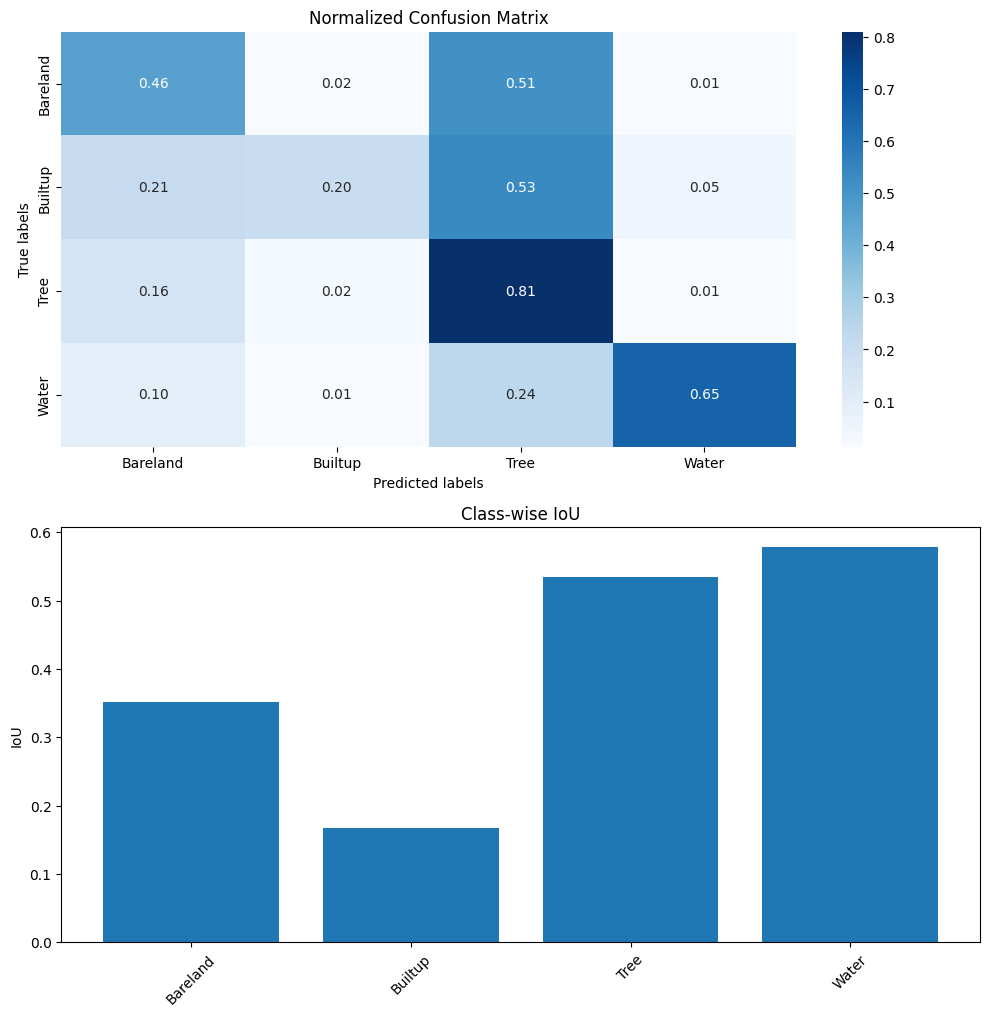

In [66]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second plot
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm, 
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')

# Plot 3: Class-wise IoU
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third plot
plt.bar(class_names, ious)
plt.title('Class-wise IoU')
plt.xticks(rotation=45)
plt.ylabel('IoU')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [67]:
# Calculate FLOPS
def get_flops():
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec([1, 128, 128, 1], model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
    return flops.total_float_ops

# Calculate Speed (FPS)
def measure_fps():
    # Warmup
    for i in range(10):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
        
    # Measure time for 100 predictions
    start_time = time.time()
    num_predictions = 100
    for i in range(num_predictions):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
    end_time = time.time()
    
    fps = num_predictions / (end_time - start_time)
    return fps

# Print Model Performance Stats
print("\n=== Model Performance Statistics ===")
flops = get_flops()
print(f"FLOPS: {flops/1e9:.2f} GFLOPs")

fps = measure_fps()
print(f"Speed: {fps:.2f} FPS")


=== Model Performance Statistics ===
FLOPS: 4.27 GFLOPs
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15